# Clustering Preprocessing
Users are clustered based on the genres of the movies they watched (rated). To get this information, the following is done:   
1. Extract genres from <i>genres</i> column in the movie metadata (json to one hot encoding)
2. merge user ratings and movie metadata
3. group user ratings so only one entry per user is retained
4. normalize genre values so the sum equals 1 for each user 
5. discard unneeded columns
6. for visualization purposes: transform data to two dimensions 

Step 1 is already performed in the prediction preprocessing.

In [1]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [8]:
# import packages
import pandas as pd
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.interpolate import interpn

from sklearn.manifold import TSNE as TSNE
from sklearn.decomposition import PCA

## 1. Load Data

In [3]:
# Load Preprocessed Movie Metadata
df_movies = pd.read_csv("clusterPreprocessing.csv")
display(df_movies.head(3))
# load user ratings
df_ratings = pd.read_csv("the-movies-dataset/ratings.csv")
df_ratings = df_ratings.drop(columns=["rating", "timestamp"])
display(df_ratings.head(3))

,Comedy,Thriller,Foreign,Documentary,Science Fiction,War,TV Movie,Horror,Drama,Action,...,Music,Mystery,History,Romance,Family,Crime,Western,Fantasy,imdbId,rating
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,114709,3.888157
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,113497,3.236953
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,113228,3.175550


,userId,movieId
0,1,110
1,1,147
2,1,858


## 2. Merge User Ratings and Movie Metadata 

In [4]:
# join ratings and metadata
df_joined = pd.merge(left=df_ratings,right=df_movies, left_on='movieId', right_on='imdbId')
 
# discard unneeded columns (all except userId and genres)
df_joined = df_joined.drop(columns=["movieId", "imdbId", "rating"])

# group values per user and aggregate genres
df_joined = df_joined.groupby("userId").sum()

# normalize genre values
df_joined = df_joined.div(df_joined.sum(axis=1), axis=0)
df_joined = df_joined.fillna(0)

display(df_joined.head(5))

,Comedy,Thriller,Foreign,Documentary,Science Fiction,War,TV Movie,Horror,Drama,Action,Animation,Adventure,Music,Mystery,History,Romance,Family,Crime,Western,Fantasy
userId,,,,,,,,,,,,,,,,,,,,
1,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.00
2,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
4,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
7,0.25,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.00
8,0.00,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.25


In [5]:
# save clustering data as csv
df_joined.to_csv("userclusterdata.csv", index=True)

## 3. Transform Data 

In [29]:
# pca: principal component analysis
a_pca = PCA(n_components=2).fit_transform(df_joined)

# tsne: t-distributed stochastic neighbor embedding
a_tsne = TSNE(n_components=2).fit_transform(df_joined)

In [32]:
# save transformed data as csv file
np.savetxt("tsne_allgenres.csv", a_tsne, delimiter=",")
np.savetxt("pca_allgenres.csv", a_pca, delimiter=",")

## 4. Explore Clustering data
### 4.1 Genre Distribution

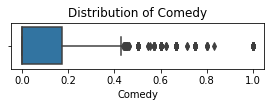

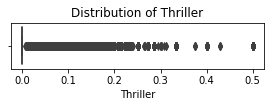

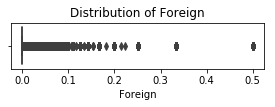

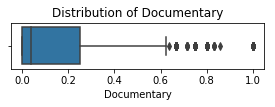

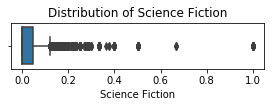

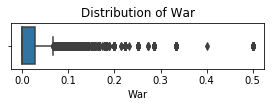

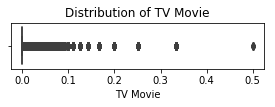

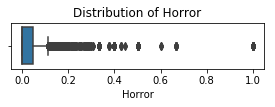

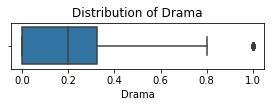

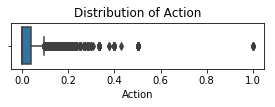

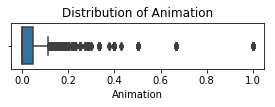

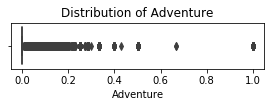

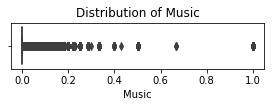

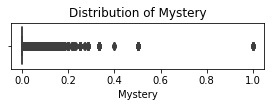

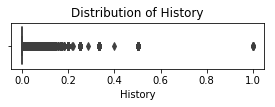

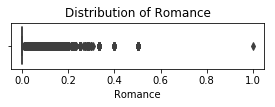

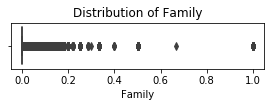

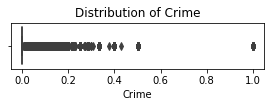

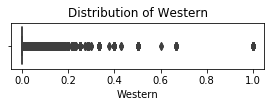

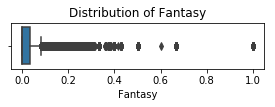

In [20]:
a = 1
for genre in list(df_joined):
    plt.figure(figsize=(10,10))
    # add a subplot
    plt.subplot(len(list(df_joined))/2,2,a)
    a = a + 1    
    #plt.tight_layout()   
    plt.title("Distribution of " + genre)
    sb.boxplot(x=genre, data=df_joined)
    plt.show()

### 4.2 Transformed Data

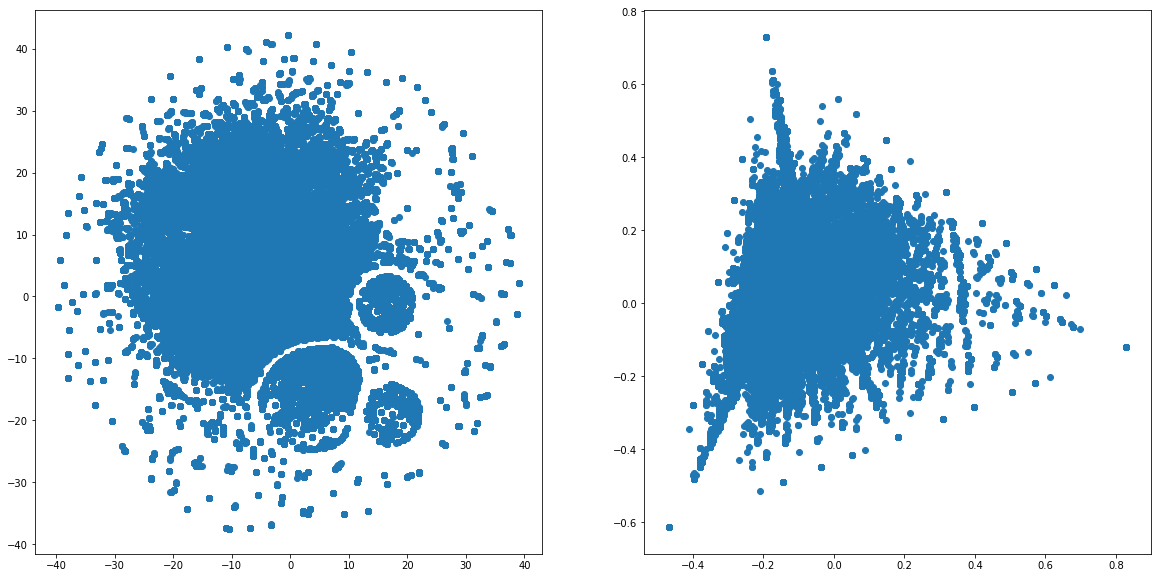

In [35]:
# create t-sne and pca plot
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(a_tsne[:, 0], a_tsne[:, 1])
plt.subplot(122)
plt.scatter(a_pca[:, 0], a_pca[:, 1])

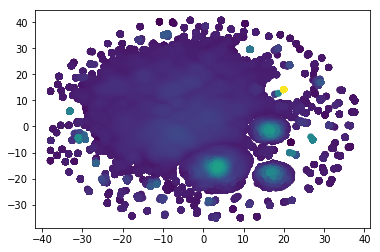

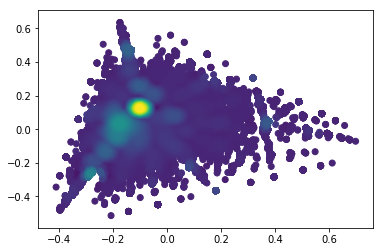

In [37]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax
density_scatter( a_tsne[:, 0], a_tsne[:, 1], bins = [30,30] )
plt.show()
density_scatter( a_pca[:, 0], a_pca[:, 1], bins = [30,30] )
plt.show()